In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, confusion_matrix
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import torch
import torch.nn as nn
from data_processing import get_data


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

1
0
NVIDIA GeForce GTX 1050 Ti


In [4]:
DATASET_NAME = "sherbrooke"

In [5]:
normal_data, abnormal_data, real_abnormal_data, real_abnormal_data_2 = get_data(DATASET_NAME)

Normal data shape: (20606, 125)
Abnormal data shape: (186, 125)
Real abnormal data shape: (406, 125)
Real abnormal data 2 shape: (406, 125)


In [6]:
# Transform torch tensors to keras tensors
normal_data = torch.Tensor(normal_data)
abnormal_data = torch.Tensor(abnormal_data)
real_abnormal_data = torch.Tensor(real_abnormal_data)
real_abnormal_data_2 = torch.Tensor(real_abnormal_data_2)

In [7]:
train_data = normal_data
test_data = torch.concat([abnormal_data, real_abnormal_data, real_abnormal_data_2])
print(train_data.shape)
print(test_data.shape)

torch.Size([20606, 125])
torch.Size([998, 125])


In [8]:
# Define the DAE
class DAE(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layers=(16,),
                 hidden_activation=nn.ReLU,
                 output_activation=nn.Sigmoid
                 ):
        super(DAE, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Add the encoding layers
        self.encoded = self.create_layers(hidden_layers, input_size)

        # Add the decoding layers with the output activation function
        self.decoded = self.create_layers(hidden_layers[-2::-1], hidden_layers[-1])
        self.decoded.append(nn.Linear(hidden_layers[0], input_size))
        self.decoded.append(self.output_activation())

    def create_layers(self, design, input_size):
        layers = []
        for i, layer in enumerate(design):
            in_features = design[i-1] if i > 0 else input_size
            out_features = layer
            layers.append(nn.Linear(in_features, out_features))
            layers.append(self.hidden_activation())

        return nn.Sequential(*layers)

    def forward(self, input):
        encoded = self.encoded(input)
        # print(self.decoded)
        decoded = self.decoded(encoded)
        return decoded

In [9]:
# Define hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
criterion = nn.MSELoss()
hidden_layers = (128,64,32,16,8)
learning_rate = 0.001

# Create the KFold object for cross validation
folds = 10
splits = KFold(n_splits=folds, shuffle=True, random_state=42)

In [10]:
# Define the model
model = DAE(input_size=train_data.shape[1], hidden_layers=hidden_layers).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [11]:
### Get initial results on abnormal data before testing
model = model.cpu()
with torch.no_grad():
    # Compute a placeholder threshold
    output = model(train_data)
    assert output.shape == train_data.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data[i], output[i]) for i in range(output.shape[0])]
    normal_score = np.mean(mse_per_sample)
    threshold = normal_score + normal_score + 3 * (np.std(mse_per_sample) + np.std(mse_per_sample))

    # Test the abnormal data with the placeholder threshold
    output = model(test_data)
    mse_per_sample = [mean_squared_error(test_data[i], output[i]) for i in range(output.shape[0])]
    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Abnormal ratio: {abnormal_test_ratio}")
model = model.to(DEVICE)

Abnormal ratio: 0.0


In [12]:
print("Training the deep autoencoder")

history = {
    'train_score': [],
    'val_score': [],
    'train_loss': [],
    'val_loss': [],
    'threshold': [],
    'abnormal_ratio': [],
    'normal_train_ratio': [],
    'normal_valid_ratio': []
}

for fold, (train_idx, val_idx) in enumerate(splits.split(train_data)):
    print(f"Fold {fold+1}")
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
    validation_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=validation_sampler)

    # Train the model on the scaled data
    for epoch in range(EPOCHS):
        total_train_loss = 0
        total_validation_loss = 0
        print(f"Epoch {epoch}")
        for i, trajectories in enumerate(train_dataloader):
            trajectories = trajectories.to(DEVICE, dtype=torch.float32)
            # print(type(trajectories[0]))

            # Forward pass
            model.zero_grad()
            output = model(trajectories)
            loss = criterion(output, trajectories)
            total_train_loss += loss / len(train_dataloader)

            # Backward pass
            loss.backward()
            optimizer.step()

        history['train_loss'].append(total_train_loss.cpu())

        # Evaluate model at this epoch
        model.eval()
        model = model.cpu()
        with torch.no_grad():
            # Get the training score
            mse_per_sample_train = []
            for i, trajectories in enumerate(train_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_train.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])
            train_score = np.mean(mse_per_sample_train)
            print(f"Train score: {train_score}")
            history['train_score'].append(train_score)

            # Get validation score
            mse_per_sample_validation = []
            for i, trajectories in enumerate(validation_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_validation.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])

                # Also get loss for rating model
                loss = criterion(output, trajectories)
                total_validation_loss += loss / len(validation_dataloader)
            validation_score = np.mean(mse_per_sample_validation)
            print(f"Validation score: {validation_score}")
            history['val_score'].append(validation_score)
            history['val_loss'].append(total_validation_loss)

            # Calculate threshold
            threshold = train_score + validation_score + 3 * (np.std(mse_per_sample_train) + np.std(mse_per_sample_validation))
            print(f"Threshold value: {threshold}")
            history['threshold'].append(threshold)

            normal_train_ratio = sum([score < threshold for score in mse_per_sample_train])/float(len(mse_per_sample_train))
            print(f"Normal train ratio: {normal_train_ratio * 100}%")
            normal_valid_ratio = sum([score < threshold for score in mse_per_sample_validation])/float(len(mse_per_sample_validation))
            print(f"Normal validation ratio: {normal_valid_ratio * 100}%")
            history['normal_train_ratio'].append(normal_train_ratio)
            history['normal_valid_ratio'].append(normal_valid_ratio)

            # Get the ratio of correctly labeled abnormal data
            predicted_test_data = model(test_data)
            assert predicted_test_data.shape == test_data.shape, "The predicted data shape is not right!"
            mse_per_sample = [mean_squared_error(test_data[i], predicted_test_data[i]) for i in range(test_data.shape[0])]

            abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
            print(f"Abnormal ratio: {abnormal_test_ratio * 100}%")
            history['abnormal_ratio'].append(abnormal_test_ratio)
        model = model.to(DEVICE)
        model.train()


Training the deep autoencoder
Fold 1
Epoch 0
Train score: 0.010562310926616192
Validation score: 0.010821215808391571
Threshold value: 0.10742458514869213
Normal train ratio: 99.71420868158533%
Normal validation ratio: 99.61183891314896%
Abnormal ratio: 12.925851703406813%
Epoch 1
Train score: 0.005362629424780607
Validation score: 0.005382094532251358
Threshold value: 0.041571774519979954
Normal train ratio: 100.0%
Normal validation ratio: 100.0%
Abnormal ratio: 14.729458917835672%
Epoch 2
Train score: 0.005483502056449652
Validation score: 0.005416207481175661
Threshold value: 0.04459316376596689
Normal train ratio: 100.0%
Normal validation ratio: 100.0%
Abnormal ratio: 23.146292585170343%
Epoch 3
Train score: 0.0029707220382988453
Validation score: 0.0029707388021051884
Threshold value: 0.024109139572829008
Normal train ratio: 100.0%
Normal validation ratio: 100.0%
Abnormal ratio: 49.298597194388776%
Epoch 4
Train score: 0.002539183711633086
Validation score: 0.0025332379154860973
T

In [13]:
print(threshold)

0.007408275967463851


In [14]:
model = model.cpu()
model.eval()

DAE(
  (encoded): Sequential(
    (0): Linear(in_features=125, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU()
  )
  (decoded): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=125, bias=True)
    (9): Sigmoid()
  )
)

In [15]:
# Test model on normal data
with torch.no_grad():
    output = model(train_data)
    assert output.shape == train_data.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data[i], output[i]) for i in range(train_data.shape[0])]

    normal_test_ratio = sum([score < threshold for score in mse_per_sample])/float(len(mse_per_sample))
    tp = len([score for score in mse_per_sample if score < threshold])
    fn = len([score for score in mse_per_sample if score >= threshold])
    print(f"Normal ratio: {normal_test_ratio * 100}%")
    print(f"tp: {tp}")
    print(f"fn: {fn}")

Normal ratio: 99.98544113365038%
tp: 20603
fn: 3


In [16]:
# Test model on normal data
with torch.no_grad():
    output = model(test_data)
    assert output.shape == test_data.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data[i], output[i]) for i in range(test_data.shape[0])]

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Abnormal ratio: {abnormal_test_ratio * 100}%")

Abnormal ratio: 93.28657314629258%


In [17]:
# Test model on normal data
with torch.no_grad():
    output = model(real_abnormal_data)
    assert output.shape == real_abnormal_data.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(real_abnormal_data[i], output[i]) for i in range(real_abnormal_data.shape[0])]

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    tn = len([score for score in mse_per_sample if score >= threshold])
    fp = len([score for score in mse_per_sample if score < threshold])
    print(f"Abnormal ratio: {abnormal_test_ratio * 100}%")
    print(f"tn: {tn}")
    print(f"fp: {fp}")

Abnormal ratio: 86.20689655172413%
tn: 350
fp: 56


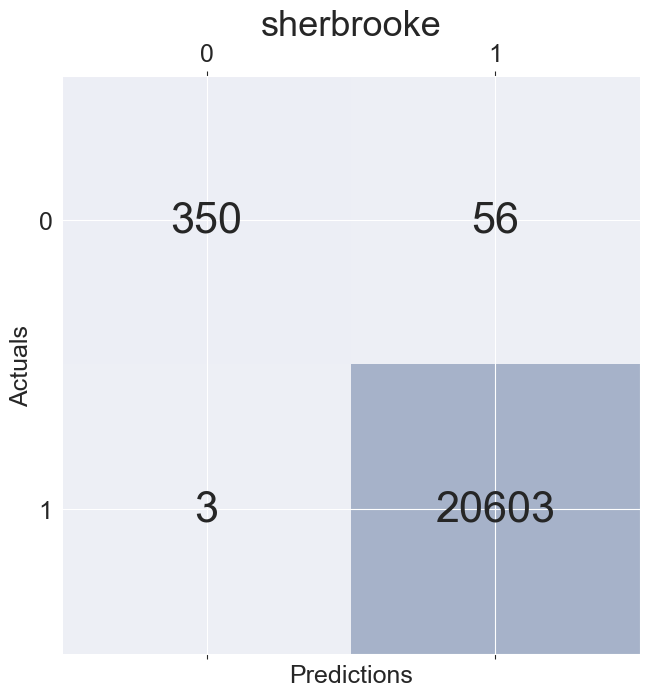

In [18]:
plt.rcParams.update({'font.size': 18})
conf_matrix = np.array([[tn, fp], [fn, tp]])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size="xx-large")

plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title(DATASET_NAME, fontsize=26)
plt.show()

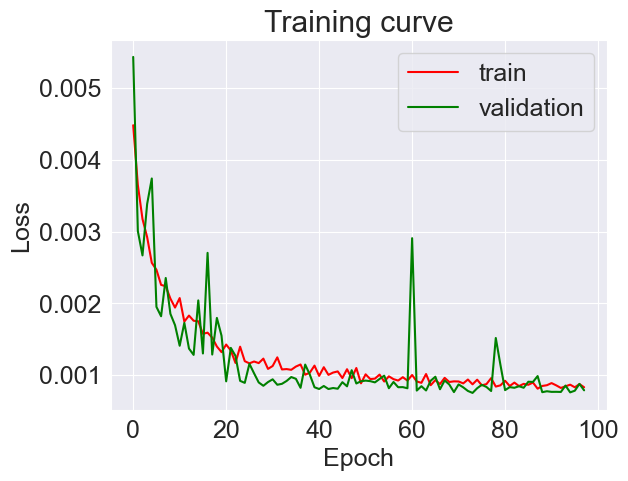

In [19]:
SKIP_PLOT = 2
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train_loss']) - SKIP_PLOT),history['train_loss'][SKIP_PLOT:],'r', label='train')
    plt.plot(range(len(history['val_loss']) - SKIP_PLOT),history['val_loss'][SKIP_PLOT:],'g', label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

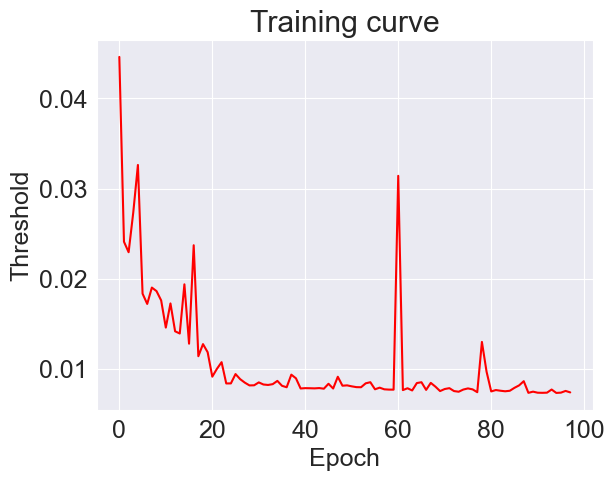

In [20]:
model = model.cpu()
model.eval()
SKIP_PLOT = 2
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['threshold']) - SKIP_PLOT),history['threshold'][SKIP_PLOT:],'r')
    plt.xlabel("Epoch")
    plt.ylabel("Threshold")
    plt.show()

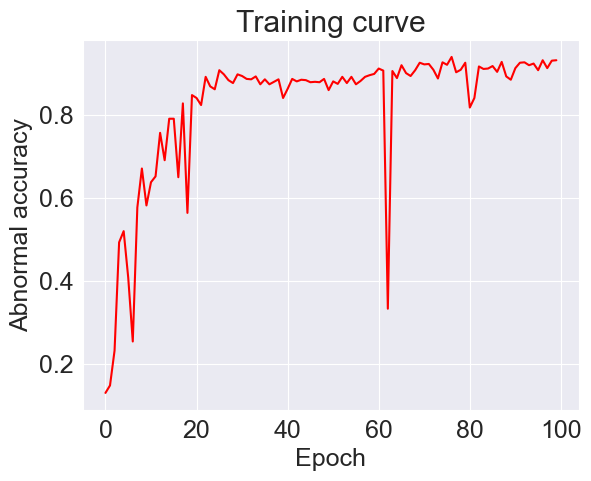

In [21]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['abnormal_ratio'])),history['abnormal_ratio'],'r')
    plt.xlabel("Epoch")
    plt.ylabel("Abnormal accuracy")
    plt.show()

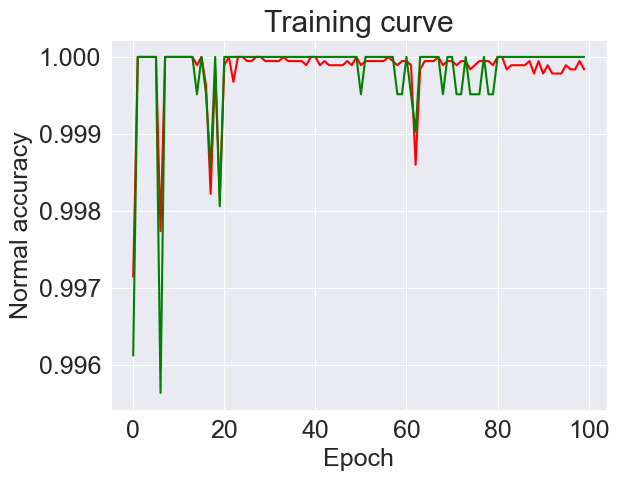

In [22]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['normal_train_ratio'])),history['normal_train_ratio'],'r')
    plt.plot(range(len(history['normal_valid_ratio'])),history['normal_valid_ratio'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Normal accuracy")
    plt.show()